<a href="https://colab.research.google.com/github/RC11-SkillsClass2022-23/ChenshiLin/blob/main/07Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
!pip install --upgrade moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
! git clone https://github.com/kenshohara/video-classification-3d-cnn-pytorch.git

Cloning into 'video-classification-3d-cnn-pytorch'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 158.63 KiB | 4.53 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [110]:
%cd video-classification-3d-cnn-pytorch/

/content/video-classification-3d-cnn-pytorch/video-classification-3d-cnn-pytorch/video-classification-3d-cnn-pytorch/video-classification-3d-cnn-pytorch/video-classification-3d-cnn-pytorch


In [111]:
import json
import os
from moviepy.editor import *
from moviepy import *
import shutil
import numpy as np

In [ ]:
def loadVideosToInfile(folder):
    videos = os.listdir(folder)
    with open('input', 'w') as inputfile:
      for v in videos:
        if v.split('.')[-1] == 'mp4':
          inputfile.write(v+'\n')


In [ ]:
loadVideosToInfile('/content/drive/MyDrive/SkillsClass/VideoFeature')

In [ ]:
! python main.py --input input --video_root /content/drive/MyDrive/SkillsClass/VideoFeature --output /content/drive/MyDrive/SkillsClass/outputFeature.json --model /content/drive/MyDrive/SkillsClass/resnet-34-kinetics-cpu.pth --mode feature --no_cuda

loading model /content/drive/MyDrive/SkillsClass/resnet-34-kinetics-cpu.pth
/content/drive/MyDrive/SkillsClass/VideoFeature/Music.mp4
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame 

In [ ]:
def readAllOutput(outputFolder):
    dictionaries = {}
    output_files = os.listdir(outputFolder)
    for f in output_files:
      print(f)
      if f.split('.')[-1] == 'json':
        file = open(outputFolder + '/' + f)
        segments = json.load(file)
        for s in segments:
          print(s['video'])
          dictionaries[s['video']] = s
    
    return dictionaries

In [ ]:
dicts = readAllOutput('/content/drive/MyDrive/SkillsClass/VideosOut')
dicts.keys()

Dance1.mp4
outputFeature.json
Music.mp4
Dance.mp4


dict_keys(['Music.mp4', 'Dance.mp4'])

In [ ]:
dicts['Dance.mp4']['clips'][0].keys()

dict_keys(['segment', 'features'])

In [ ]:
# here keyFilmName is the name of the film that you want to find a match for, and the feature dictionary is 
# the dictionary that is given as output by the readAllOutput function

def searchForMatch(keyFilmName, featureDictionary):
    # create variables to keep track of the best clips
    bestRangeStart = 0
    bestRangeFilmName = ''
    bestRangeScore = 1000000000
    
    # first read the features of the keyFilm into keyFeatures
    keyClips = featureDictionary[keyFilmName]['clips']
    keyFeatures = []
    for c in keyClips:
      keyFeatures.append(np.array(c['features']))
    
    # now enter a for loop to go through all films, and see what the best matching sequence is 
    # (we make sure not to check the keyFilm itself by checking it's not that filename)
    for film in featureDictionary.keys():
        if not film == keyFilmName:
          filmClips = featureDictionary[film]['clips']
          filmFeatures = []
          for c in filmClips:
            filmFeatures.append(np.array(c['features']))
          for i in range(len(filmFeatures)-len(keyFeatures)):
            distance = 0
            for j in range(len(keyFeatures)):
              d = np.linalg.norm(filmFeatures[i+j]-keyFeatures[j])
              distance += d
              if distance < bestRangeScore:
                bestRangeScore = distance
                bestRangeStart = i
                bestRangeFilmName = film
                
            
            # so now here 'film' is a filename (which is the key in the feature dictionary of that film)
            # first load the features in a 'filmFeatures' list like we did for key Features
            # then look at the provided code from the lecture to see how to iterate through the other
            # list of features to find the best segment. Now just make sure to also register what film
            # name the best matching segment is from. 
            
    # create a list containing the filename, start and nr of clips
    matchingFragment = [bestRangeFilmName, bestRangeStart, len(keyFeatures)]
    
    return matchingFragment

    # First implement it for the best matching one, then expand it to return the n best matching ones as a list,
    # with n as an argument in the function

In [ ]:
matchingFragment = searchForMatch("Dance.mp4", dicts)

In [ ]:
# this is a helper function to which you give the fragment (the output of the searchForMatch function), and it returns
# a moviepy film object (which you can then save)

def extractFragment(fragment, filmFolder):
    # here adapt the code from the lecture, but make it so that it works for any input fragment list
    # the output of the function above: [bestRangeFilmName, bestRangeStart, len(keyFeatures)]
    
    filmFileName = fragment[0]
    start = fragment[1]
    nrClips = fragment[2]
    
    filmPath = os.path.join(filmFolder, filmFileName)
    print(filmPath)
    filmVideo = VideoFileClip(filmPath)
    filmfps = filmVideo.fps
    filmFrameLength = 1/filmfps
    
    nrFrames = nrClips * 16
    startFrame = start * 16
    
    startTime = startFrame * filmFrameLength
    endTime = startTime + nrFrames * filmFrameLength
    
    filmMatchedVideo = filmVideo.subclip(startTime, endTime)
    
    
    return filmMatchedVideo

    # This function should read all .json files in the output folder, and combine them into one large dictionary

In [ ]:
# a small piece of code that moves all processed input films to the processed films folder

input_films_processed = os.listdir('/content/drive/MyDrive/SkillsClass/VideoCut')
for file in input_films_processed:
    try:
        shutil.move(os.path.join('/content/drive/MyDrive/SkillsClass/VideoFeature',file),'/content/drive/MyDrive/SkillsClass/VideoFeature')
    except:
        print(file + ' not moved')

Dance1.mp4 not moved


In [ ]:
# read all output with the function declared above

dicts= readAllOutput('/content/drive/MyDrive/SkillsClass/VideosOut')

Dance1.mp4
outputFeature.json
Music.mp4
Dance.mp4


In [ ]:
dicts.keys()

dict_keys(['Music.mp4', 'Dance.mp4'])

In [ ]:
fragment = searchForMatch('Dance.mp4', dicts)

In [ ]:
fragment

['Music.mp4', 18, 31]

In [ ]:
# extract the fragment from the film
filmFolder = '/content/drive/MyDrive/SkillsClass/VideoFeature'
carpetFilm = extractFragment(fragment, filmFolder)

/content/drive/MyDrive/SkillsClass/VideoFeature/Music.mp4


In [ ]:
# display the film fragment

carpetFilm.ipython_display()

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
# save the film fragment


carpetFilm.write_videofile("/content/drive/MyDrive/SkillsClass/VideosOut/fragment.mp4", audio_codec='aac')

Moviepy - Building video /content/drive/MyDrive/SkillsClass/VideosOut/fragment.mp4.
MoviePy - Writing audio in fragmentTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/SkillsClass/VideosOut/fragment.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/SkillsClass/VideosOut/fragment.mp4


In [ ]:
carpetFilm.write_videofile("/content/drive/MyDrive/SkillsClass/VideosOut/carpet.mp4",audio_codec='aac')

Moviepy - Building video /content/drive/MyDrive/SkillsClass/VideosOut/carpet.mp4.
MoviePy - Writing audio in carpetTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/SkillsClass/VideosOut/carpet.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/SkillsClass/VideosOut/carpet.mp4


In [ ]:
carpetFilm.duration

38.15384615384615

In [ ]:
frame=carpetFilm.get_frame(18)


In [ ]:
from PIL import Image

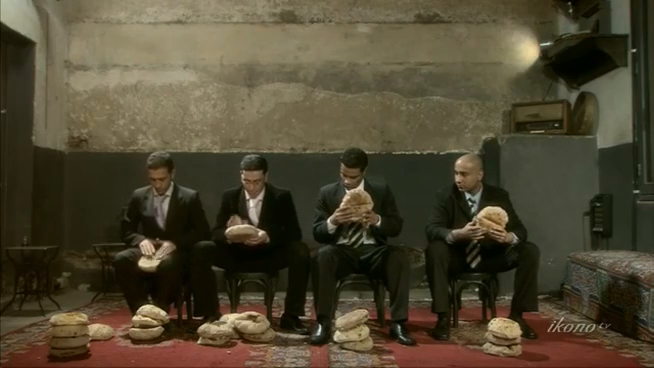

In [ ]:
Image.fromarray(frame,'RGB')

In [ ]:
def GG(lujing,changshipin,bestRangeStart):
  kbVideo = VideoFileClip(lujing)
  kbfps = kbVideo.fps
  kbFrameLength = 1/kbfps

  nrFrames = len(changshipin)*16
  startFrame = bestRangeStart*16

  startTime = startFrame*kbFrameLength
  endTime = startTime+nrFrames*kbFrameLength

  kbMatchedMhVideo = kbVideo.subclip(startTime,endTime)
  return kbMatchedMhVideo

In [ ]:
ggFeatures[bestRangeStart]

In [ ]:
lujing=r"/content/drive/MyDrive/ud/video/shaow.mp4"
changshipin=shFeatures

kbMatchedMhVideo=GG(lujing,changshipin)